Epoch 0: Loss = 7.5054e+03
Epoch 20: Loss = 6.6198e+02
Epoch 40: Loss = 6.2753e+02
Epoch 60: Loss = 6.2392e+02
Epoch 80: Loss = 6.2197e+02
Epoch 100: Loss = 6.2044e+02
Epoch 120: Loss = 6.1938e+02
Epoch 140: Loss = 6.1864e+02
Epoch 160: Loss = 6.1804e+02
Epoch 180: Loss = 6.1752e+02
Epoch 200: Loss = 6.1706e+02
Epoch 220: Loss = 6.1668e+02
Epoch 240: Loss = 6.1634e+02
Epoch 260: Loss = 4.7730e+02
Epoch 280: Loss = 1.6069e+02
Epoch 300: Loss = 3.9251e+01
Epoch 320: Loss = 1.6969e+01
Epoch 340: Loss = 6.1282e+00
Epoch 360: Loss = 7.5149e+00
Epoch 380: Loss = 2.5670e+00
Epoch 400: Loss = 3.0340e+00
Epoch 420: Loss = 1.5983e+00
Epoch 440: Loss = 1.2752e+00
Epoch 460: Loss = 1.1352e+00
Epoch 480: Loss = 1.6010e+00
Epoch 500: Loss = 9.5463e-01
Epoch 520: Loss = 8.6549e-01
Epoch 540: Loss = 8.1084e-01
Epoch 560: Loss = 1.1274e+00
Epoch 580: Loss = 7.0312e-01
Epoch 600: Loss = 6.4426e-01
Epoch 620: Loss = 5.9821e-01
Epoch 640: Loss = 1.5554e+00
Epoch 660: Loss = 5.4193e-01
Epoch 680: Loss = 4.

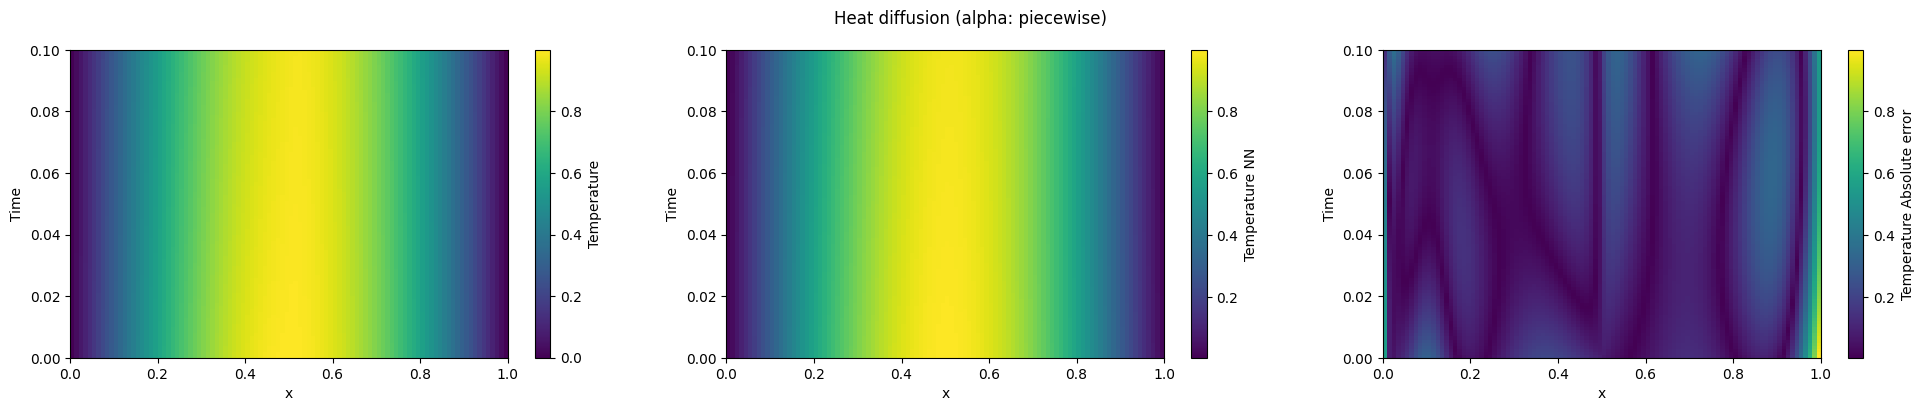

In [162]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt


class alpha_network(nn.Module):

    def __init__(self):
        super(alpha_network, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=1, out_features=12),
            nn.Tanh(),
            nn.Linear(in_features=12, out_features=12),
            nn.Tanh(),
            nn.Linear(in_features=12,out_features=1)
        )

    def forward(self, x):
        return self.net(x)
    

class u_network(nn.Module):

    def __init__(self):
        super(u_network, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=2, out_features=12),
            nn.Tanh(),
            nn.Linear(in_features=12, out_features=12),
            nn.Tanh(),
            nn.Linear(in_features=12,out_features=1)
        )

    def forward(self, xt):
        return self.net(xt)


class DataLoss(nn.Module):

    def forward(self, u, u_pred):
        loss = torch.sum((u-u_pred)**2)

        return loss
    

class PDEResidualLoss(nn.Module):

    def forward(self, xt, u_pred, alpha_pred, nt):

        # Compute gradients of u_pred w.r.t input xt (x and t)
        du_dxt = autograd.grad(
            outputs=u_pred,
            inputs=xt,
            grad_outputs=torch.ones_like(u_pred),
            create_graph=True,
            retain_graph=True
        )[0]  # shape [N, 2]

        u_x = du_dxt[:, 0].unsqueeze(-1)  # ∂u/∂x
        u_t = du_dxt[:, 1].unsqueeze(-1)  # ∂u/∂t

        # Compute ∂²u/∂x² by differentiating u_x w.r.t xt again, select derivative w.r.t x
        u_xx = autograd.grad(
            outputs=u_x,
            inputs=xt,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True
        )[0][:, 0].unsqueeze(-1)

        # residual
        alpha_expanded = alpha_pred.repeat_interleave(nt, dim=0)  # 20 because nx=20; shape: [nx * nt, 1]
        residual = u_t - alpha_expanded * u_xx

        loss = torch.sum(residual**2)

        return loss


class AlphaRegularizationLoss(nn.Module):

    def forward(self, alpha_pred, x):
        alpha_x = autograd.grad(alpha_pred, x, torch.ones_like(alpha_pred), create_graph=True)[0]
        loss = torch.mean(alpha_x**2)
        return loss

class Loss(nn.Module):

    def __init__(self, pde_coefficient: float = 1.0, alpha_reg_coefficient: float = 1.0):
        
        super().__init__()
        self.data_loss = DataLoss()
        self.pde_loss = PDEResidualLoss()
        self.alpha_regularization = AlphaRegularizationLoss()

        self.pde_coefficient = pde_coefficient
        self.alpha_reg_coefficient = alpha_reg_coefficient

    def forward(self, x, xt, u_pred, u_obs, alpha_pred, nt):

        loss = (
            self.data_loss(u=u_obs, u_pred=u_pred) 
            + self.pde_coefficient * self.pde_loss(xt=xt, u_pred=u_pred, alpha_pred=alpha_pred, nt=nt) 
            + self.alpha_reg_coefficient * self.alpha_regularization(alpha_pred=alpha_pred, x=x)
        )

        return loss

from torch.utils.data import Dataset, DataLoader
import numpy as np

# Heat equation solver using explicit finite differences

def generate_mesh_grid(alpha_x, nx=100, nt=100, L=1.0, T=0.1):

    dx = L / (nx - 1)
    
    # Stability check for explicit scheme
    max_alpha = alpha_x.max().item()
    dt_stable = 0.5 * dx**2 / max_alpha
    dt = min(T / nt, dt_stable * 0.9)  # reduce a bit below the limit

    x = torch.linspace(0, L, nx)
    t = torch.arange(0, nt, dtype=torch.float32)

    # create input for u_network
    X, T = torch.meshgrid(x, t, indexing='ij') # shape [nx, nt]
    xt = torch.stack([X.flatten(), T.flatten()], dim=1) # shape [nx*nt, 2]

    return {"xt": xt, "x": x, "t": t, "nx": nx, "nt": nt, "dt": dt, "dx": dx}


def solve_heat_equation(alpha_x, x, t, dt, dx, u0, nx):

    u = u0.clone()
    u_sol = [u.unsqueeze(0)]

    for _ in range(1, t.shape[0]):
        u_new = u.clone()
        for i in range(1, nx - 1):
            u_new[i] = u[i] + dt * alpha_x[i] * (u[i+1] - 2*u[i] + u[i-1]) / dx**2
        u_new[0] = 0.0
        u_new[-1] = 0.0
        u = u_new
        u_sol.append(u.unsqueeze(0))

    return torch.cat(u_sol, dim=0)


# Random diffusivity profiles
def generate_alpha_profile(nx, kind="smooth"):
    x = torch.linspace(0, 1, nx)
    if kind == "smooth":
        return 1.0 + 0.5 * torch.sin(2 * np.pi * x)
    elif kind == "piecewise":
        alpha = torch.ones_like(x)
        alpha[x > 0.5] = 0.2
        return alpha
    elif kind == "random":
        return torch.rand_like(x) * 0.8 + 0.2
    else:
        raise ValueError("Unknown kind")


# Torch Dataset
class HeatEquationDataset(Dataset):

    def __init__(self, n_samples=100, nx=100, nt=100, L=1.0, T=0.1):

        self.data = []

        for _ in range(n_samples):

            # alpha
            alpha_kind = np.random.choice(["smooth", "piecewise", "random"])
            alpha_x = generate_alpha_profile(nx, kind=alpha_kind)
            # mesh
            mesh = generate_mesh_grid(alpha_x=alpha_x, nx=nx, nt=nt, L=L, T=T)
            # boundaries
            u0 = torch.sin(np.pi * mesh["x"])  # initial condition
            # solve PDE
            u_xt = solve_heat_equation(
                alpha_x=alpha_x, 
                x=mesh["x"],
                t=mesh["t"],
                dt=mesh["dt"],
                dx=mesh["dx"],
                u0=u0,
                nx=mesh["nx"]
            )

            item_information = mesh | {
                "kind": alpha_kind,
                "alpha": alpha_x,     # shape: (nx,)
                "u_xt": u_xt,         # shape: (nt+1, nx)
                "u0": u0,
            }

            item_information["x"] = item_information["x"].reshape(-1,1)

            self.data.append(item_information)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# --- Training Loop ---
from tqdm import tqdm

def train_one_epoch(dataset, u_net, alpha_net, optimizer, loss_function):

    epoch_loss = 0

    for data_batch in dataset: #tqdm(dataset, desc=f"Batches"):

        # predict u(x,t), alpha(x)
        x = data_batch["x"].requires_grad_(True)
        xt = data_batch["xt"].requires_grad_(True)
        t = data_batch["t"].requires_grad_(True)
        u_xt = data_batch["u_xt"].requires_grad_(True)

        u_pred = u_net(xt).reshape(data_batch["nx"], data_batch["nt"])

        alpha_pred = alpha_net(x=x)

        optimizer.zero_grad()

        loss = loss_function(
            x=x, 
            xt=xt,
            u_pred=u_pred,
            u_obs=u_xt,
            alpha_pred=alpha_pred.requires_grad_(True),
            nt=data_batch["nt"]
        )

        epoch_loss += loss

        loss.backward()
        
        optimizer.step()

    epoch_loss = epoch_loss / len(dataset)

    return epoch_loss


def train(dataset, u_net, alpha_net, epochs=1000, lr=5e-3):

    optimizer = torch.optim.Adam(list(u_net.parameters()) + list(alpha_net.parameters()), lr=lr)
    loss_function = Loss()

    losses = []
    
    for epoch in range(epochs):

        epoch_loss = train_one_epoch(dataset=dataset, u_net=u_net, alpha_net=alpha_net, optimizer=optimizer, loss_function=loss_function)
        losses.append(epoch_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {epoch_loss.item():.4e}")


import matplotlib.pyplot as plt


# Example usage
def plot_sample(sample, u_xt_pred):
    
    u_xt = sample["u_xt"].detach().numpy()
    u_xt_pred = u_xt_pred.reshape(sample["nx"], sample["nt"]).detach().numpy()

    # Plot
    fig, ax = plt.subplots(figsize=(24, 4), nrows=1, ncols=3)

    im0 = ax[0].imshow(u_xt, aspect="auto", origin="lower", extent=[0, 1, 0, 0.1])
    fig.colorbar(im0, ax=ax[0], label="Temperature")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("Time")

    im1 = ax[1].imshow(u_xt_pred, aspect="auto", origin="lower", extent=[0, 1, 0, 0.1])
    fig.colorbar(im1, ax=ax[1], label="Temperature NN")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("Time")

    im2 = ax[2].imshow(np.abs(u_xt - u_xt_pred), aspect="auto", origin="lower", extent=[0, 1, 0, 0.1])
    fig.colorbar(im1, ax=ax[2], label="Temperature Absolute error")
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("Time")

    fig.suptitle(f"Heat diffusion (alpha: {sample['kind']})")

    plt.show()


# --- Main Execution ---
if __name__ == "__main__":

    # Create Dataset
    dataset = HeatEquationDataset(n_samples=2, nx=100, nt=100)

    # Define PINNS
    alpha_net = alpha_network()
    u_net = u_network()

    # training
    u_net.train()
    alpha_net.train()

    train(
        dataset=dataset,
        u_net=u_net,
        alpha_net=alpha_net
    )

    # plot
    u_net.eval()
    alpha_net.eval()
    sample = dataset[0]
    u_xt = u_net(xt=sample["xt"])
    plot_sample(sample, u_xt)
